In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2024-10-12 09:21:38.376096: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-12 09:21:38.376235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-12 09:21:38.556574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Parsing data from XML file

In [4]:
# /kaggle/input/car-plate-detection/input/car-plate-detection
path = glob('/kaggle/input/car-plate-detection/annotations/*.xml')
labels_dict = dict(filepath=[], img = [],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_img_name = root.find('filename').text
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    labels_dict['img'].append(member_img_name)

In [5]:
df = pd.DataFrame(labels_dict)
df = df.sort_values(by=['filepath'])
df = df.reset_index(drop=True)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,img,xmin,xmax,ymin,ymax
0,/kaggle/input/car-plate-detection/annotations/...,Cars0.png,226,419,125,173
1,/kaggle/input/car-plate-detection/annotations/...,Cars1.png,134,262,128,160
2,/kaggle/input/car-plate-detection/annotations/...,Cars10.png,140,303,5,148
3,/kaggle/input/car-plate-detection/annotations/...,Cars100.png,175,214,114,131
4,/kaggle/input/car-plate-detection/annotations/...,Cars101.png,167,240,202,220


In [6]:
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/kaggle/input/car-plate-detection/images',filename_image)
    return filepath_image

In [7]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#

['/kaggle/input/car-plate-detection/images/Cars0.png',
 '/kaggle/input/car-plate-detection/images/Cars1.png',
 '/kaggle/input/car-plate-detection/images/Cars10.png',
 '/kaggle/input/car-plate-detection/images/Cars100.png',
 '/kaggle/input/car-plate-detection/images/Cars101.png',
 '/kaggle/input/car-plate-detection/images/Cars102.png',
 '/kaggle/input/car-plate-detection/images/Cars103.png',
 '/kaggle/input/car-plate-detection/images/Cars104.png',
 '/kaggle/input/car-plate-detection/images/Cars105.png',
 '/kaggle/input/car-plate-detection/images/Cars106.png']

## Verify data

In [8]:
image_path[87]

'/kaggle/input/car-plate-detection/images/Cars177.png'

In [9]:
df[df['img'] == 'Cars177.png']

,filepath,img,xmin,xmax,ymin,ymax
87,/kaggle/input/car-plate-detection/annotations/...,Cars177.png,149,272,166,193


In [10]:
file_path = image_path[87] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882 
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=149, x1=272, y0=166, y1=193, xref='x', yref='y',line_color='cyan')

# 3. DATA PROCESSING

## 3.1 Read data

In [11]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    img,xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

## 3.2 SPLIT TRAIN AND TEST SET

In [12]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [13]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((346, 224, 224, 3), (87, 224, 224, 3), (346, 4), (87, 4))

# 4. DEEP LEARNING FOR OBJECT DETECTION

## 4.1 INCEPTION-RESNET-V2 MODEL BUILDING¶

In [14]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [15]:
# Complie model
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 73,663,490 (281.00 MB)

 Trainable params: 73,602,946 (280.77 MB)

 Non-trainable params: 60,544 (236.50 KB)

# Extract text from image
## 4.2 INCEPTION-RESNET-V2 TRAINING AND SAVE

In [16]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=180,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/180


I0000 00:00:1728725127.272214     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1728725127.519143     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.0636   

W0000 00:00:1728725223.819905     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1728725236.705785     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 308s 4s/step - loss: 0.0631 - val_loss: 0.0340
Epoch 2/180


W0000 00:00:1728725248.700883     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - loss: 0.0145 - val_loss: 0.0224
Epoch 3/180
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - loss: 0.0074 - val_loss: 0.0200
Epoch 4/180
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - loss: 0.0044 - val_loss: 0.0173
Epoch 5/180
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - loss: 0.0034 - val_loss: 0.0161
Epoch 6/180
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - loss: 0.0024 - val_loss: 0.0153
Epoch 7/180
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - loss: 0.0024 - val_loss: 0.0161
Epoch 8/180
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - loss: 0.0019 - val_loss: 0.0151
Epoch 9/180
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 216ms/step - loss: 0.0021 - val_loss: 0.0162
Epoch 10/180
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - loss: 0.0015 - val_loss: 0.0165
Epoch 11/180
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - loss: 0.0017 - val_loss: 0.0216
Epoch 12/180
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - loss: 0.0020 - val_loss: 0.0199
Epoch 13/180
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 218ms/st

In [17]:
model.save('./object_detection.h5')

In [18]:
# Instal Tesseract
!apt-get update
!apt-get install -y tesseract-ocr

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 https://packages.cloud.google.com/apt gcsfuse-focal InRelease [1227 B]   
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]        
Get:4 https://packages.cloud.google.com/apt cloud-sdk InRelease [1618 B]       
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:6 https://packages.cloud.google.com/apt google-fast-socket InRelease [1071 B]
Get:7 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]      
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Get:9 https://packages.cloud.google.com/apt gcsfuse-focal/main amd64 Packages [27.8 kB]
Get:10 https://packages.cloud.google.com/apt cloud-sdk/main amd64 Packages [3321 kB]
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [1726 kB]
Get:12 https://packages.cloud.google.com/apt cloud-sdk/main all Packages [1546 kB]
Get:13 https://pack

In [94]:
import pytesseract as pt

In [153]:
path = '/kaggle/input/car-plate-detection/images/Cars111.png'
image = load_img(path) #PIL object
image = np.array(image, dtype=np.uint8) #8 bit array (0,255)
image1 = load_img(path, target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0 #normalized

In [154]:
h,w,d = image.shape
print('height of the image =',h)
print('weight of the image =',w)

height of the image = 338
weight of the image = 600


In [155]:
image_arr_224.shape

(224, 224, 3)

In [156]:
test_arr = image_arr_224.reshape(1, 224, 224, 3)
test_arr.shape

(1, 224, 224, 3)

In [157]:
#make predictions
coords = model.predict(test_arr)
coords

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[0.5445279 , 0.7935535 , 0.48587012, 0.61212724]], dtype=float32)

In [158]:
#denormalize the value
denorm = np.array([w, w, h, h])
coords = coords * denorm
coords

array([[326.71673298, 476.13208294, 164.22410154, 206.89900863]])

In [159]:
coords = coords.astype(np.int32)
coords

array([[326, 476, 164, 206]], dtype=int32)

(326, 164) (476, 206)


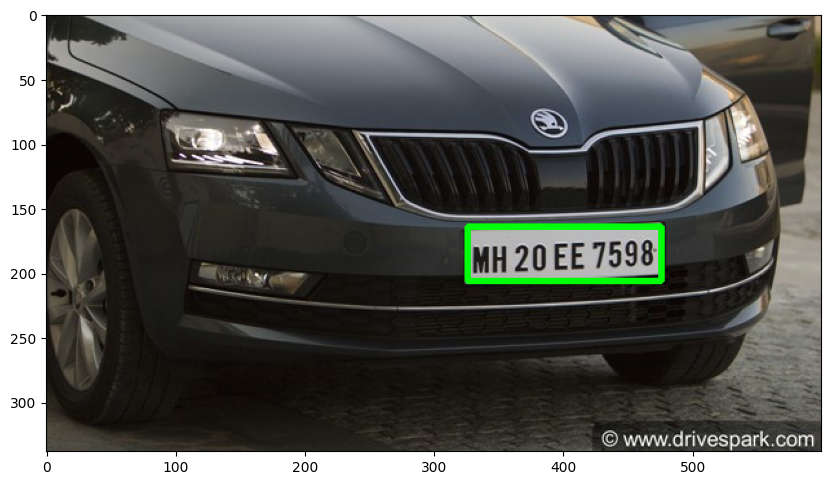

In [160]:
#draw bounding on top the image
xmin, xmax, ymin, ymax = coords[0]
pt1 = (xmin, ymin)
pt2 = (xmax, ymax)
print(pt1, pt2)
cv2.rectangle(image,pt1,pt2,(0,255,9),3)

plt.figure(figsize=(10,8))
plt.imshow(image)
plt.show()

In [161]:
#Create pipeline
path = '/kaggle/input/car-plate-detection/images/Cars111.png'
def object_detection(path):
    #read image
    image = load_img(path) #PIL object
    image = np.array(image, dtype=np.uint8) #8 bit array (0,255)
    image1 = load_img(path, target_size=(224,224))
    #data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 #normalized
    test_arr = image_arr_224.reshape(1, 224, 224, 3)
    #make predictions
    coords = model.predict(test_arr)
    #denormalize the value
    denorm = np.array([w, w, h, h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    #draw bounding on top the image
    xmin, xmax, ymin, ymax = coords[0]
    pt1 = (xmin, ymin)
    pt2 = (xmax, ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,9),3)
    return image, coords

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
(326, 164) (476, 206)


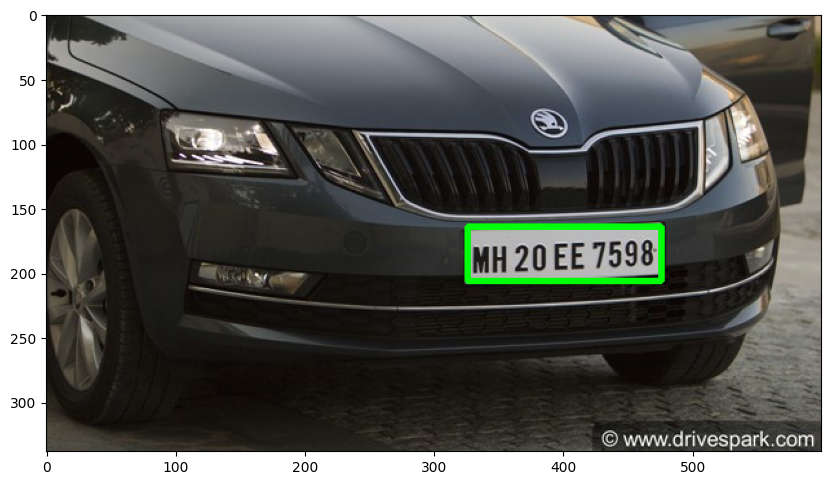

In [162]:
path = '/kaggle/input/car-plate-detection/images/Cars111.png'
image, cods = object_detection(path)

plt.figure(figsize=(10,8))
plt.imshow(image)
plt.show()

In [163]:
img = np.array(load_img(path))
xmin, xmax, ymin, ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]

<function matplotlib.pyplot.show(close=None, block=None)>

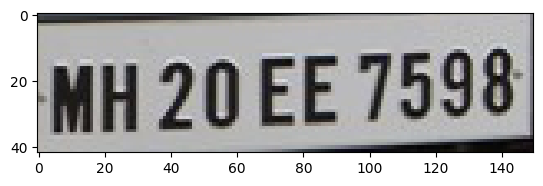

In [164]:
plt.imshow(roi)
plt.show

In [165]:
# Extract text from image
texr = pt.image_to_string(roi)
print(texr)

MH 20 EE 7598

